In [ ]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_absolute_error

# Генерация данных

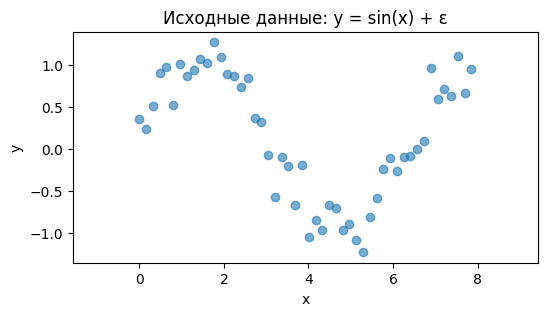

In [ ]:
# Генерация данных
np.random.seed(0)

# Формируем обучающую выборку:
n_samples = 50
X = np.linspace(0, 2.5 * np.pi, n_samples).reshape(-1, 1)
epsilon = np.random.normal(0, 0.2, size=n_samples)
Y = np.sin(X).ravel() + epsilon

# набор x, для которых будет строиться прогноз:
#XX = np.linspace(0, 2.5 * np.pi, 200).reshape(-1, 1)
XX = np.linspace(-0.5*np.pi, 3*np.pi, 400).reshape(-1, 1)

# Визуализация исходных данных
plt.figure(figsize=(6, 3))
plt.scatter(X, Y, alpha=0.6)
plt.title("Исходные данные: y = sin(x) + ε")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(XX.min(), XX.max())
plt.show()

# Обычная линейная регрессия

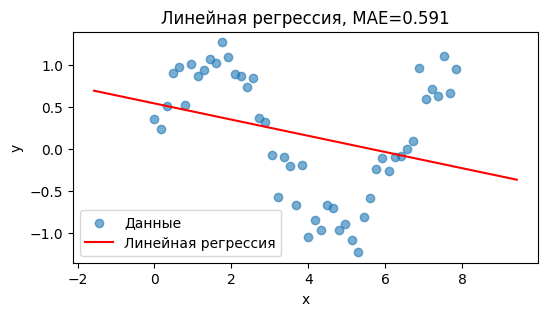

In [ ]:
# Линейная регрессия на исходных данных
model = LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)
mae = mean_absolute_error(Y, Y_pred)

# Визуализация линейной регрессии
plt.figure(figsize=(6, 3))
plt.scatter(X, Y, alpha=0.6, label="Данные")
YY_pred = model.predict(XX)
plt.plot(XX, YY_pred, color='red', label="Линейная регрессия")
plt.title(f"Линейная регрессия, MAE={mae:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Дискретизованные признаки

`KBinsDiscretizer` — это инструмент из `scikit-learn` для дискретизации непрерывных признаков.

Он преобразует каждый непрерывный признак $x$ в набор бинарных признаков, где каждый бин (интервал) представлен отдельной колонкой. Если значение $x$ выходит за пределы диапазона, оно **экстраполируется в крайний бин**, то есть присваивается либо первому, либо последнему бину.

## Шаги работы

1. **Определение диапазона признака**

   Для признака $x$ вычисляем минимальное и максимальное значения:
   $$
   x_{\min} = \min(x), \quad x_{\max} = \max(x)
   $$

2. **Разбиение на интервалы**

   Диапазон $[x_{\min}, x_{\max}]$ делится на $K$ равных интервалов ширины
   $$
   W = \frac{x_{\max} - x_{\min}}{K}
   $$
   
   Каждому интервалу $i$ соответствует диапазон:
   $$
   \text{bin}_i = \left[x_{\min} + i \cdot W,\ x_{\min} + (i+1) \cdot W\right)
   $$
   для $i = 0, 1, \dots, K-2$, а последний бин включает правую границу:
   $$
   \text{bin}_{K-1} = \left[x_{\min} + (K-1) \cdot W,\ x_{\max}\right]
   $$

3. **Присвоение биновых индексов с экстраполяцией**

   Каждому значению $x_j$ признака присваивается индекс $k$ того бина, в который оно попадает:
   $$
   k_j =
   \begin{cases}
   0, & \text{если } x_j < x_{\min} \\
   i, & \text{если } x_j \in \text{bin}_i \\
   K-1, & \text{если } x_j > x_{\max}
   \end{cases}
   $$

4. **One-hot кодирование**

   После определения индексов формируется **one-hot-вектор** длины $K$, где единица стоит на позиции бина, куда попал $x$:
   $$
   \mathbf{b}_j = [0, \dots, 0, \underbrace{1}_{k_j\text{-ая позиция}}, 0, \dots, 0]
   $$

Больше информации см. в [документации](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization).

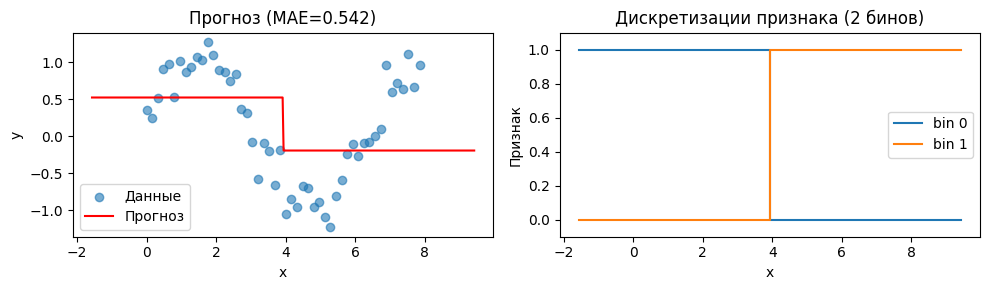

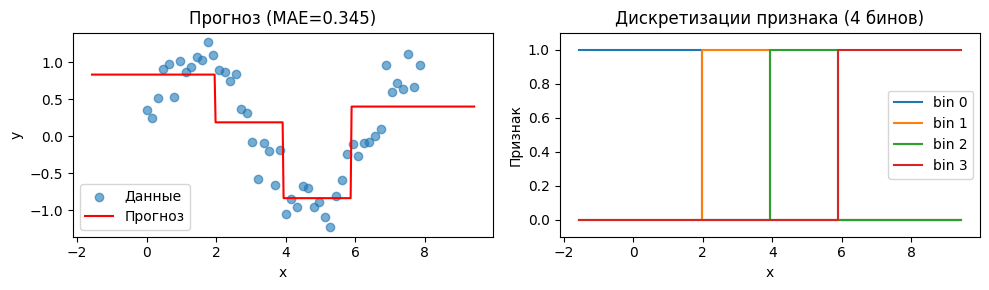

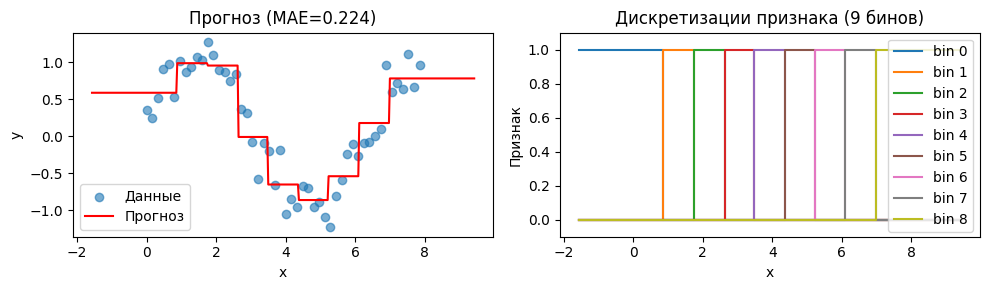

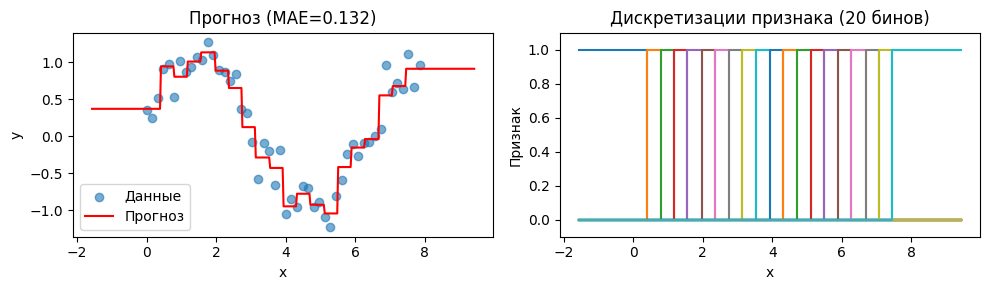

In [ ]:
for bins in [2,4,9,20]:
    # Бинаризация признака
    discretizer = KBinsDiscretizer(n_bins=bins, encode='onehot-dense', strategy='uniform')
    X_binned = discretizer.fit_transform(X)

    # Обучение линейной регрессии
    model_binned = LinearRegression()
    model_binned.fit(X_binned, Y)

    # Прогноз на обучающих данных
    Y_pred_train = model_binned.predict(X_binned)
    mae_binned = mean_absolute_error(Y, Y_pred_train)

    # Для визуализации
    XX_binned = discretizer.transform(XX)  # бинаризация для плотной сетки
    YY_pred = model_binned.predict(XX_binned)

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Слева: данные и прогноз
    axes[0].scatter(X, Y, alpha=0.6, label="Данные")
    axes[0].plot(XX, YY_pred, color='red', label="Прогноз")
    axes[0].set_title(f"Прогноз (MAE={mae_binned:.3f})")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].legend()

    # Справа: бинаризованные признаки
    for i in range(bins):
        label = f'bin {i}' if bins <= 10 else None
        axes[1].step(XX.ravel(), XX_binned[:, i], where='mid', label=label)

    axes[1].set_ylim(-0.1, 1.1)
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("Признак")
    axes[1].set_title(f"Дискретизации признака ({bins} бинов)")
    if bins <= 10:
        axes[1].legend()

    plt.tight_layout()
    plt.show()

### К полученным признакам можно добавить исходный

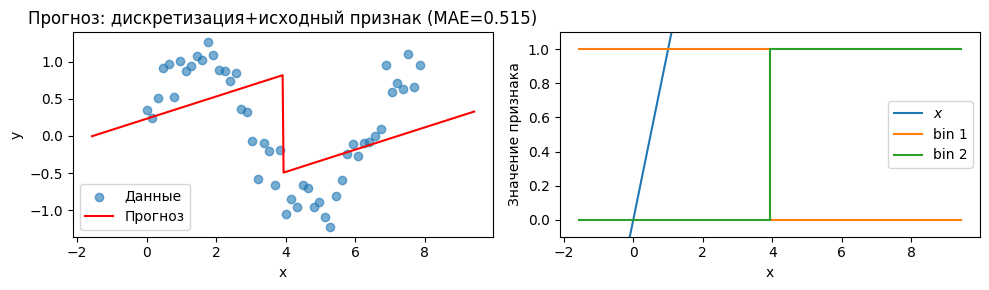

In [ ]:
# Дискретизация по 2 бинам
discretizer = KBinsDiscretizer(n_bins=2, encode='onehot-dense', strategy='uniform')
X_binned = discretizer.fit_transform(X)
XX_binned = discretizer.transform(XX)

# Объединяем исходный признак и бинаризованный
X_combined = np.hstack([X, X_binned])

# Обучение линейной регрессии
model_combined = LinearRegression()
model_combined.fit(X_combined, Y)

# Прогнозы
Y_pred_train = model_combined.predict(X_combined)
mae_combined = mean_absolute_error(Y, Y_pred_train)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

XX_combined = np.hstack([XX, XX_binned])
YY_pred = model_combined.predict(XX_combined)

# --- Слева: данные и прогноз ---
axes[0].scatter(X, Y, alpha=0.6, label="Данные")
axes[0].plot(XX, YY_pred, color='red', label="Прогноз")
axes[0].set_title(f"Прогноз: дискретизация+исходный признак (MAE={mae_combined:.3f})")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].legend()

# --- Справа: визуализация признаков ---
# Исходный признак
axes[1].plot(XX, XX, label='$x$', color='tab:blue')
# Бинарные признаки


axes[1].step(XX.ravel(), XX_binned[:, 0], where='mid', label='bin 1', color='tab:orange')
axes[1].step(XX.ravel(), XX_binned[:, 1], where='mid', label='bin 2', color='tab:green')
axes[1].set_ylim(-0.1, 1.1)
axes[1].set_xlabel("x")
axes[1].set_ylabel("Значение признака")
axes[1].legend()

plt.tight_layout()
plt.show()

# Полиномиальные признаки

`PolynomialFeatures` — это инструмент для генерации **полиномиальных признаков** из исходных непрерывных признаков.
    
Он преобразует каждый исходный признак $x$ в набор новых признаков вида $x^1, x^2, \dots, x^d$, где $d$ — степень полинома.

В случае набора признаков $x_1,x_2,\ldots$ включаются также попарные произведения разных порядков $x_1^{n_1}  \cdot  x_2^{n_2} \cdot \ldots$, что позволяет поделировать **совместное влияние признаков** на отклик.

Больше информации см. в [документации](https://scikit-learn.org/stable/modules/preprocessing.html#polynomial-features).

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Зададим различимые цвета для визуализации
colors = ['tab:blue', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

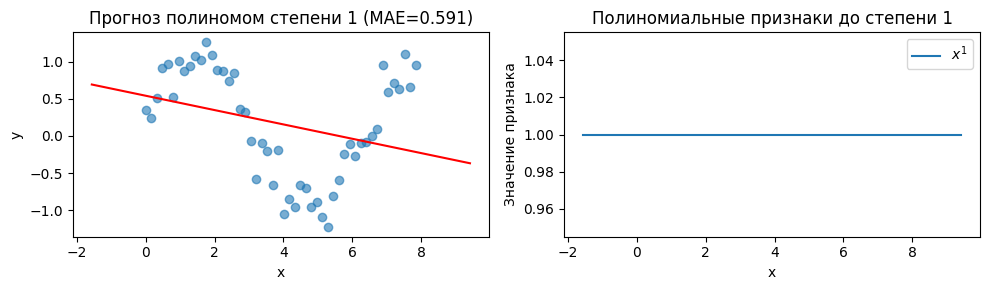

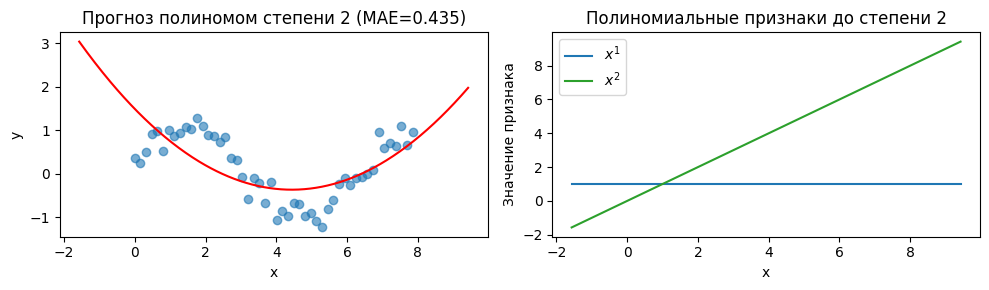

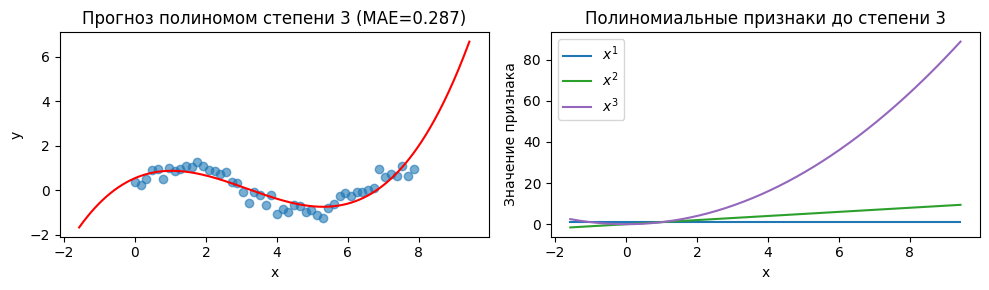

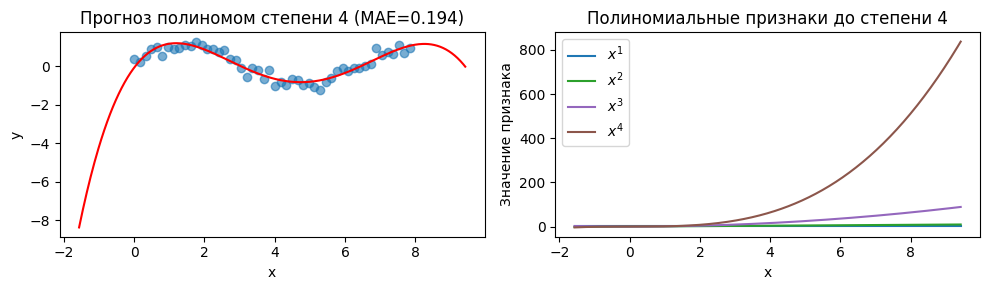

In [ ]:
degrees = [1, 2, 3, 4]

for deg in degrees:
    # Полиномиальные признаки
    poly = PolynomialFeatures(degree=deg)
    X_poly = poly.fit_transform(X)

    # Линейная регрессия
    model = LinearRegression()
    model.fit(X_poly, Y)

    # MAE на обучающих данных
    Y_pred_train = model.predict(X_poly)
    mae = mean_absolute_error(Y, Y_pred_train)

    # Плотная сетка для визуализации прогноза
    XX_poly = poly.transform(XX)
    YY_pred = model.predict(XX_poly)

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Слева: данные и прогноз
    axes[0].scatter(X, Y, alpha=0.6)
    axes[0].plot(XX, YY_pred, color='red')
    axes[0].set_title(f"Прогноз полиномом степени {deg} (MAE={mae:.3f})")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # Справа: полиномиальные признаки
    for i in range(deg):
        axes[1].plot(XX, XX_poly[:, i], color=colors[i % len(colors)], label=f'$x^{i+1}$')

    axes[1].set_xlabel("x")
    axes[1].set_ylabel("Значение признака")
    axes[1].set_title(f"Полиномиальные признаки до степени {deg}")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Сплайновые признаки

`SplineTransformer` — это инструмент из `scikit-learn`, который преобразует числовой признак $x$ в значения **B-сплайновых базисных функций**.  
Он используется для построения гибких, гладких аппроксимаций нелинейных зависимостей, сохраняя при этом линейность модели по коэффициентам.

Нерпрервыный признак кодируется значениями базисных функций:
$$
x \to \{B_{i,d}(x)\}_{i}
$$

B-сплайны строятся на основе набора **узлов**:
$$
t_0 \le t_1 \le \dots \le t_{n_{\text{knots}}-1}.
$$

B-сплайновые базисные функции $B_{i,d}(x)$ определяются рекурсивно:

**Базовый случай (нулевая степень):**
$$
B_{i,0}(x) =
\begin{cases}
1, & t_i \le x < t_{i+1}, \\
0, & \text{иначе}.
\end{cases}
$$

**Рекуррентное определение для степени $d \ge 1$:**
$$
B_{i,d}(x) =
\frac{x - t_i}{t_{i+d} - t_i} B_{i,d-1}(x)
+ \frac{t_{i+d+1} - x}{t_{i+d+1} - t_{i+1}} B_{i+1,d-1}(x).
$$

**Свойства B-сплайнов**

- 🔹 **Локальная поддержка:** каждая функция $B_{i,d}(x)$ отлична от нуля только на ограниченном числе интервалов — влияет только на небольшой участок оси $x$.
- 🔹 **Непрерывность:** для сплайна степени $d$ гарантируется непрерывность до производной $d-1$-го порядка.
- 🔹 **Положительность:** $B_{i,d}(x) \ge 0$.
- 🔹 **Нормировка:** в любой точке $x$ сумма всех базисных функций равна 1:
  $$
  \sum_i B_{i,d}(x) = 1.
  $$

**Влияние параметров**

| Параметр | Эффект |
|-----------|--------|
| `n_knots` | Чем больше узлов, тем **больше гибкости**, но выше риск переобучения. |
| `degree` | Определяет **гладкость** и **порядок аппроксимации** (степень полинома внутри каждого интервала). |



Подробнее о реализации сплайновых признаков см. в [документации sklearn](https://scikit-learn.org/stable/modules/preprocessing.html#spline-transformer).

С теорией B-сплайнов можно ознакомиться [здесь](https://personal.math.vt.edu/embree/math5466/lecture10.pdf).

In [ ]:
from sklearn.preprocessing import SplineTransformer

### Влияние числа узлов

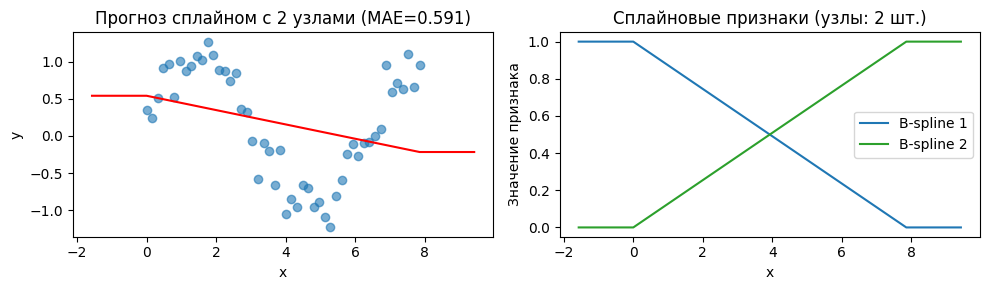

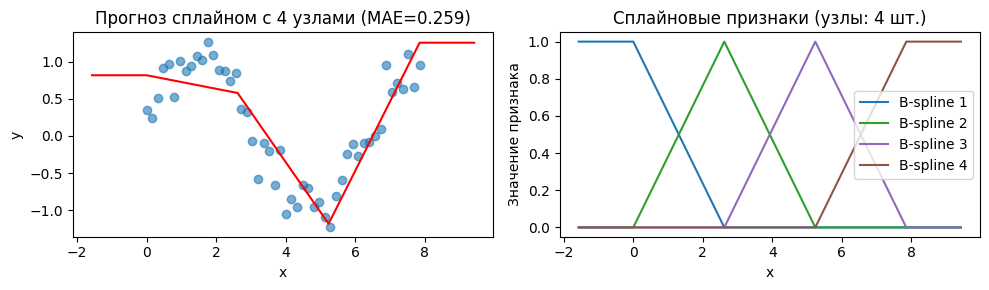

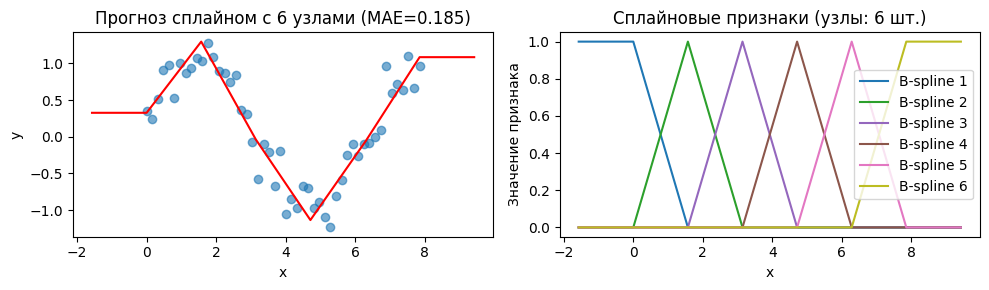

In [ ]:
# Разные числа контрольных точек (аналог степеней полинома)
n_knots_list = [2, 4, 6]  # чем больше узлов, тем гибче сплайн

for n_knots in n_knots_list:
    # Создание сплайновых признаков
    spline = SplineTransformer(n_knots=n_knots, degree=1)
    X_spline = spline.fit_transform(X)

    # Линейная регрессия
    model = LinearRegression()
    model.fit(X_spline, Y)

    # MAE на обучающих данных
    Y_pred_train = model.predict(X_spline)
    mae = mean_absolute_error(Y, Y_pred_train)

    # Плотная сетка для визуализации прогноза
    XX_spline = spline.transform(XX)
    YY_pred = model.predict(XX_spline)

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Слева: данные и прогноз
    axes[0].scatter(X, Y, alpha=0.6)
    axes[0].plot(XX, YY_pred, color='red')
    axes[0].set_title(f"Прогноз сплайном с {n_knots} узлами (MAE={mae:.3f})")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # Справа: сплайновые признаки
    for i in range(X_spline.shape[1]):
        axes[1].plot(XX, XX_spline[:, i], color=colors[i % len(colors)], label=f'B-spline {i+1}')

    axes[1].set_xlabel("x")
    axes[1].set_ylabel("Значение признака")
    axes[1].set_title(f"Сплайновые признаки (узлы: {n_knots} шт.)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### Влияние степени сплайнов

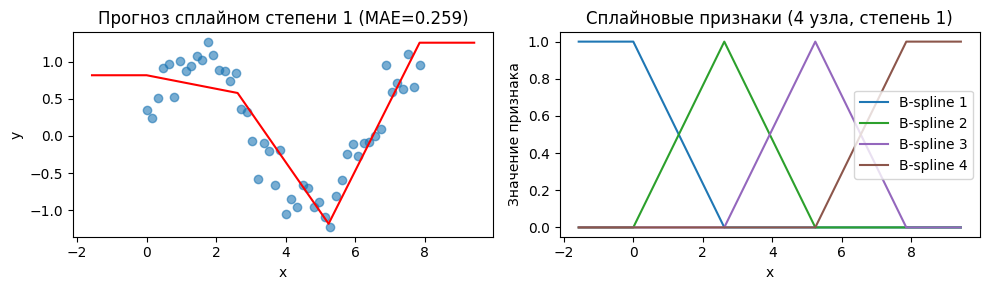

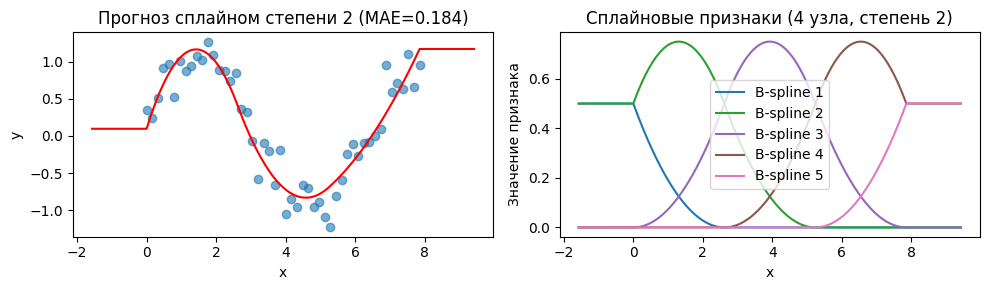

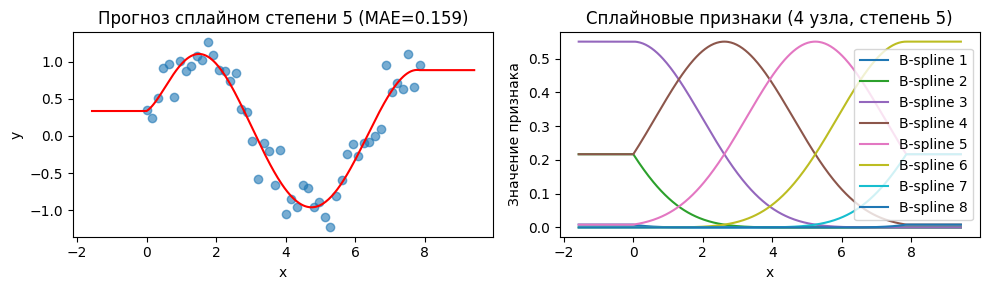

In [ ]:
# Фиксируем количество узлов
n_knots = 4
# Разные степени сплайнов
degrees = [1, 2, 5]

for deg in degrees:
    # Создание сплайновых признаков
    spline = SplineTransformer(n_knots=n_knots, degree=deg)
    X_spline = spline.fit_transform(X)

    # Линейная регрессия
    model = LinearRegression()
    model.fit(X_spline, Y)

    # MAE на обучающих данных
    Y_pred_train = model.predict(X_spline)
    mae = mean_absolute_error(Y, Y_pred_train)

    # Плотная сетка для визуализации прогноза
    XX_spline = spline.transform(XX)
    YY_pred = model.predict(XX_spline)

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Слева: данные и прогноз
    axes[0].scatter(X, Y, alpha=0.6)
    axes[0].plot(XX, YY_pred, color='red')
    axes[0].set_title(f"Прогноз сплайном степени {deg} (MAE={mae:.3f})")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # Справа: сплайновые признаки
    for i in range(X_spline.shape[1]):
        axes[1].plot(XX, XX_spline[:, i], color=colors[i % len(colors)], label=f'B-spline {i+1}')

    axes[1].set_xlabel("x")
    axes[1].set_ylabel("Значение признака")
    axes[1].set_title(f"Сплайновые признаки ({n_knots} узла, степень {deg})")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Обратим внимание, что при сплановых признаках экстраполяция осуществляется константой.

При прогнозировании временных данных с ярко выраженной сезонностью можно адаптировать код так,
чтобы признаки экстраполировались периодично ([источник](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#periodic-splines)):

![Пример графика](https://scikit-learn.org/stable/_images/sphx_glr_plot_polynomial_interpolation_003.png)



В ноутбуке представлены лишь самые популярные методы генерации дополнительных признаков.

На практике вы можете использовать любые другие преобразовния над исходными данными,
которые порождают новые осмысленные признаки, приводящие к повышению качества прогнозов.

Эти преобразования зависят от целевой задачи, располагаемых данных и используемой модели прогнозирования.
Генерация новых признаков по исходным называется feature engineering.